In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import xgboost as xgb
import seaborn as sns

from sklearn import ensemble
from sklearn.model_selection import train_test_split
from os.path import join
from sklearn import metrics
from omegaconf import OmegaConf

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["TOKENIZERS_PARALLELISM"] = "False"

In [2]:
cd ../..

/Users/diat.lov/GitHub/RecSys-hse-fall-2021


In [3]:
from src.hw2.utils import read_dfs, to_categorical, group_by_plot
from src.hw2.models import SimpleXgbRecommender
from src.hw2.configs import SIMPLE_CONFIG_PATH, CONFIG_PATH
from src.hw2.tokenizer.tokenize import load_tokenizer
from src.hw2.embedding_dataset import Dataset

### 0. Предобработка данных

In [38]:
file_names = ["members.csv", "sample_submission.csv", "song_extra_info.csv", "songs.csv", "test.csv", "train.csv"]

In [39]:
members_df, submissions_df, songs_extra_info_df, songs_df, test_df, train_df = read_dfs(file_names)

### `members.csv`:

In [9]:
np.unique(np.array(members_df.gender).astype(str), return_counts=True)

(array(['female', 'male', 'nan'], dtype='<U6'), array([ 7096,  7405, 19902]))

In [10]:
members_df_clean = members_df.drop(columns=["gender"])

 - выбросим фичу с полом (80% данных отсотсвует);

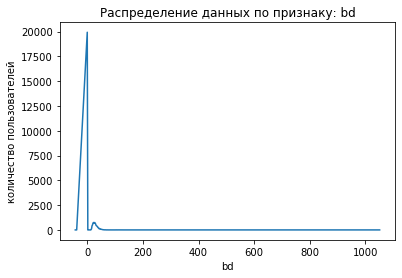

In [11]:
group_by_plot(members_df, "bd", "city", "Распределение данных по признаку: bd", "bd", "количество пользователей")

In [12]:
bd_mask = members_df_clean.bd != 0
members_df_clean.loc[bd_mask, "bd"] = 1

 - из признака bd сделаем бинарную фичу, т.к. ~60% данных (с учетом предыдущих пунктов), относятся к 1 группе;

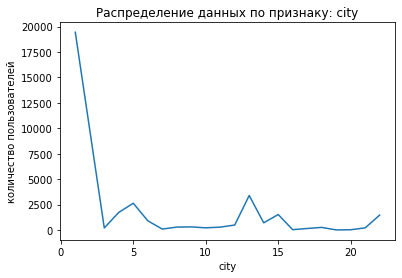

In [13]:
group_by_plot(members_df, "city", "bd", "Распределение данных по признаку: city", "city", "количество пользователей")

In [14]:
city_mask = members_df_clean.city != 1
members_df_clean.loc[city_mask, "city"] = 0

- айдишники городов сгруппируем тоже в 2 группы, на графике видно, что большая часть пользователей у нас из одного города;

### `song_info.csv`:

In [15]:
songs_df.isnull().sum()/songs_df.isnull().count()*100

song_id         0.000000
song_length     0.000000
genre_ids       4.098558
artist_name     0.000000
composer       46.655257
lyricist       84.712409
language        0.000044
dtype: float64

- выбросим фичу lyricist, т.к. ~85% данных по ней отсутствуют;
- остальные фичи заполним дополнительной категорией 'unknown'.

In [16]:
songs_df_clean = songs_df.drop(columns=["lyricist"])

In [17]:
songs_df_clean = songs_df_clean.fillna(value="unknown")

In [18]:
songs_df_clean.isnull().sum()/songs_df_clean.isnull().count()*100

song_id        0.0
song_length    0.0
genre_ids      0.0
artist_name    0.0
composer       0.0
language       0.0
dtype: float64

### `train_df`:

 - замерджим датасеты (members, songs, train);

In [19]:
train_df = train_df.merge(members_df_clean, on="msno")
train_df = train_df.merge(songs_df_clean, on="song_id")

In [20]:
train_df.isnull().sum()/train_df.isnull().count()*100

msno                      0.000000
song_id                   0.000000
source_system_tab         0.336830
source_screen_name        5.622596
source_type               0.291963
target                    0.000000
city                      0.000000
bd                        0.000000
registered_via            0.000000
registration_init_time    0.000000
expiration_date           0.000000
song_length               0.000000
genre_ids                 0.000000
artist_name               0.000000
composer                  0.000000
language                  0.000000
dtype: float64

In [21]:
train_df = train_df.fillna(value="unknown")

 - колонки с датой переведем в формат datetime и оставим только год для более высокой обобщающией способности;

In [22]:
train_df.registration_init_time = pd.to_datetime(
    train_df.registration_init_time, format='%Y%m%d', errors='ignore').dt.year
train_df.expiration_date = pd.to_datetime(train_df.expiration_date, format='%Y%m%d', errors='ignore').dt.year

  - проведем мапинг категориальных фичей;

In [23]:
train_df = to_categorical(train_df)

In [24]:
train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,language
0,8158,74668,1,7,6,1,1,0,7,2012,2017,206471,285,3277,14581,8
1,25914,74668,0,11,6,0,0,1,4,2015,2017,206471,285,3277,14581,8
2,29618,74668,3,8,3,1,1,0,7,2012,2017,206471,285,3277,14581,8
3,27013,74668,3,8,3,1,0,1,9,2011,2017,206471,285,3277,14581,8
4,16246,74668,3,8,3,0,0,1,9,2007,2017,206471,285,3277,14581,8


отобразим heatmap, чтобы выделить коррелирующие друг с другом фичи;

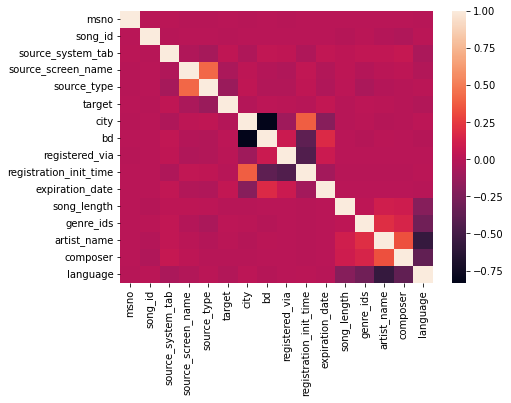

In [25]:
plt.figure(figsize=[7,5])
sns.heatmap(train_df.corr())
plt.show()

фичи с высокой корреляцией:

- source type & sorce_screen_name
- city & registration_init_time
- bd & city
- regersted_via & registration_init_time
- bd & registration_init_time
- artist_name & language
- genre_ids & language

выбросим: "bd", "source_screen_name", "registration_init_time"

In [26]:
train_df = train_df.drop(columns=["bd", "source_screen_name", "registration_init_time"])

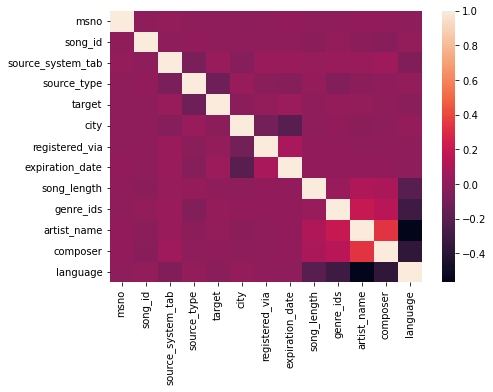

In [27]:
plt.figure(figsize=[7,5])
sns.heatmap(train_df.corr())
plt.show()

### 1. Обучение Xgboost на отобранных признках

In [9]:
config = OmegaConf.load(SIMPLE_CONFIG_PATH)
config = OmegaConf.to_container(config, resolve=True)

Обучим Xgboost для решения задачи бинарной классификации, параметры модели:

In [28]:
config

{'seed': 9,
 'k': 5,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 10,
 'eval_metric': 'auc'}

In [29]:
train_target = train_df.pop('target')

In [30]:
simple_model = SimpleXgbRecommender(**config)
aucs, feature_importances = simple_model.train(train_df, train_target)

In [41]:
df_result = pd.DataFrame({"mean of 5 folder auc": [np.round(np.mean(aucs), 3)],
                          "std of 5 folder auc": [np.round(np.std(aucs), 3)]})
df_result.loc[0]

mean of 5 folder auc    0.659
std of 5 folder auc     0.012
Name: 0, dtype: float64

- посмотрим на наиболее значимые фичи:

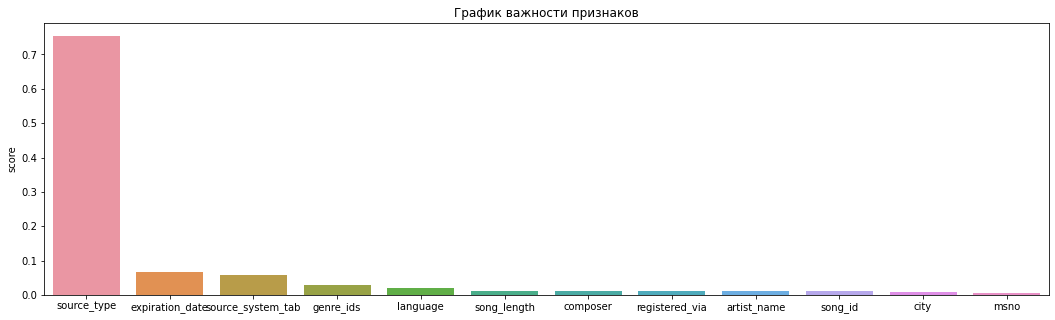

In [182]:
data = pd.DataFrame(
    data=feature_importances, index=train_df.columns, columns=["score"]).sort_values(by = "score", ascending=False)
plt.figure(figsize=[18, 5])
sns.barplot(x = data.index, y = data.score)
plt.title('График важности признаков')
plt.show()

### 2. Создание эмбеддингов

Обучение xgb в первом задании показало, что `source_type` в принципе единственная значимая фича для классификатора, хочется как-то более разумно использовать информацию об авторах песен и композиторах, попробовала следующее:

- собираю в скрипт и произвожу предобработку данных, раскиданную по ноутбуку выше;
- тренирую токенайзер на всех именах авторов песен и композиторах, пустые строки заменяю на токен [UNK];
- составляю эмбеддинги размерности 5 (с padding и turnication) для каждой песни;
- стакаю два эмбеддинга вместе – получаю эмбеддинг песни;
- тренирую unsupervised алгоритм для поиска ближайших соседей на всех эмбеддингах песен;
- тренирую xgboost со всеми фичами, как в 1 пункте (кроме имени артиста и композитора) на train части датасета;
- для val части датасета создаю эмбеддинги для пользователей – усредняю эмбеддинги всех их песен;
- по этому эмбеддингy пользователя с помощью обученного алгоритма поиска ближайших достаю 150 соседей;
- для тех песен, по которым есть инфо с пользователями из валидационного датасета прогоняю xgboost;
- ранжирую (если есть что ранжировать из оставшихся от 150 кандидатов) песни по скору xgb;
- выдаю рекомендацию пользователю.


Результаты:
- recall 0.45 говорит о том, что сейчас чуть больше половины рекомендаций у меня не релевантных, скорее всего это бага в составлении эмбедингов для пользователей, поправлю, пересчитаю метрики;

- в текущей реализации у меня есть ограничение на инференс, xgb тренировался на данных из train датасета, которых может и не быть для всех 150 ближайших соседей, т.е. этих соседей я сразу отбрасываю -> не рекомендую ничего нового; можно было учить xgb только на фичах песен и пользователей (убрать ограничение на днные о взаимодействии), но я этого не делала т.к. `source_type` seems to be key feature; ну еще в теории можно какой-то top-n кандидатов от поиска ближайших докидывать в рекомендации в качестве exploration.

### TODO
вытащить рекомендации для пользователей, чтобы посмотреть глазами на ближайших

### AFTER SOFT

UPD1: отдебажила сосоставление эмбеддингов (теперь в составление эмбеддинга пользователя берется усреднение только по песням пользователя с положительным взаимодействием);

In [5]:
from src.hw2.models import KNNXGB

In [5]:
config = OmegaConf.load(CONFIG_PATH)
config = OmegaConf.to_container(config, resolve=True)

In [6]:
alg = KNNXGB(**config)

In [7]:
recall, auc = alg.train(n_train_samples=300_000, evaluate=True)

Filtering data...
Song ids count: 300000.
Tokenize data...
Started KNN training...
Songs embedding count: 300000.
Started XGB training...
Getting KNN predictions...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluated:: 100%|████████████████████████| 86974/86974 [01:54<00:00, 761.51it/s]


In [15]:
# 150 кандидатов для ранжирования
print(f"recall@10: {recall}; \nauc@10: {auc}")

recall@10: 0.6194926568758344; 
auc@10: 0.7400324948984119


UPD2: попробовала увеличить количество кандидатов для ранжирования, метрики просели;

In [16]:
config = OmegaConf.load(CONFIG_PATH)
config = OmegaConf.to_container(config, resolve=True)
alg = KNNXGB(**config)
recall, auc = alg.train(n_train_samples=300_000, evaluate=True)

Filtering data...
Song ids count: 300000.
Tokenize data...
Started KNN training...
Songs embedding count: 300000.
Started XGB training...
Getting KNN predictions...


Evaluated:: 100%|████████████████████████| 86992/86992 [03:05<00:00, 468.07it/s]


In [18]:
# 300 кандидатов для ранжирования
print(f"recall@10: {recall}; \nauc@10: {auc}")

recall@10: 0.532608695652174; 
auc@10: 0.7181203829942703


UPD3: посмотрела глазами на рекомендации (в сетапе 150 кандидатов для ранжирования):

In [6]:
config = OmegaConf.load(CONFIG_PATH)
config = OmegaConf.to_container(config, resolve=True)
alg = KNNXGB(**config)
alg.train(n_train_samples=500_000, evaluate=False)

Filtering data...
Song ids count: 500000.
Tokenize data...
Started KNN training...
Songs embedding count: 500000.
Started XGB training...


In [412]:
recommendations, true_preferences = alg.predict(user_ids=[70, 36, 72, 80, 90, 114])

Predicted:: 100%|████████████████████████████████| 5/5 [00:00<00:00, 364.33it/s]


In [416]:
generes = ["asian", "teen songs", "asian and us pop", "dancing rock", "rnb", "pop, classical, asian"]

In [414]:
df = pd.DataFrame({"user preference": pd.Series(true_preferences), 
                   "genre summary": pd.Series(generes), 
                   "recommendations": pd.Series(recommendations)})

In [350]:
df

,user preference,genre summary,recommendations
0,"[BoA, BoA, 孫燕姿 (Yanzi Sun), 大嘴巴 (DA Mouth), 孫燕...",asian,"[杜德偉 (Alex To), 杜德偉 (Alex To), 側田 (Justin Lo),..."
1,"[Teen Top, The Chainsmokers, Meghan Trainor, H...",teen songs,"[Corinne Bailey Rae, Seo In Guk, Backstreet Bo..."
2,"[蔡健雅 (Tanya Chua), 蘇打綠 (Sodagreen), Dua Lipa, ...",asian and us pop,"[Wheesung, Union of Sound, Greatest Christmas ..."
3,"[ToCo Summer Dance, P!nk, Redfoo]",dancing rock,"[Panic! At The Disco, 王心凌 (Cyndi Wang), 2006 K..."
4,[Chris Brown],rnb,"[風格童星組合, 風格童星組合, Namaste, 林淑容, 林淑容, 林淑容, 風格童星組..."
5,"[Bruno Mars, 周杰倫 (Jay Chou), One Direction, Va...","pop, classical, asian","[羅志祥 (Show Lo), 張信哲 (Jeff Chang), 羅志祥 (Show Lo..."


Результаты: 
- добавление эмбеддингов на этапе одбора кандидатов принесло +10% к auc (74%, если отбирать 150 кандидатов для ранжирования);
- при дальнейщем увеличении количества кандидатов для ранжирования auc снижается.

Сhery-pick рекомендаций:
- отобрала нескольих пользователей с +/- интерпритируемыми музыкальными вкусами по лайкнутым исполнителям (интерпретация в колонке genre summary в df выше) и выдавала 10 рекомендаций с 8 лучшими после ранжирования и 2 рандомными из отобранных кандидатоы в качестве exploration части; 
- с teen music и dancing rock в целом хорошее попадание, к азиатом тоже азиатов рекомендует, но bias в сторону корейско-китайской музыки есть большой и по остальным рекомендациям.